In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
    


In [2]:
def load_data():
    """Load and preprocess the data"""
    #load data
    constructors = pd.read_csv('data/constructors.csv')
    constructor_standings = pd.read_csv('data/constructor_standings.csv')
    races = pd.read_csv('data/races.csv')
    pit_stops = pd.read_csv('data/pit_stops.csv')
    status = pd.read_csv('data/status.csv')
    results = pd.read_csv('data/results.csv')


#merge constructors standings with races and constructors
    constructor_standings = constructor_standings.merge(races[['raceId', 'year', 'round']], on = 'raceId').merge(constructors[['constructorId', 'name', 'nationality']], on = 'constructorId')

    #merge pit stops with races and constructors
    pit_stops = pit_stops.merge(
        races[['raceId', 'year', 'round']], on='raceId').merge(
        results[['raceId', 'driverId', 'constructorId']], on=['raceId', 'driverId']
    ).merge(
        constructors[['constructorId', 'name']], on='constructorId'
    )


    # Merge status with races and constructors
    results_with_status = results.merge(
    status, 
    left_on='statusId', 
    right_on='statusId'
    ).merge(
    races[['raceId', 'year', 'round']], 
    on='raceId'
    ).merge(
    constructors[['constructorId', 'name']], 
    on='constructorId'
    )
    
    return constructors, constructor_standings, pit_stops, results_with_status, races

    

In [3]:
def analyze_team_performance_evolution(constructor_standings):
    """Analyze team performance evolution over time"""
    # Calculate yearly performance metrics
    yearly_performance = constructor_standings.groupby(['year', 'name']).agg({
        'points': 'sum',
        'wins': 'sum',
        'position': 'mean'
    }).reset_index()
    
    # Calculate rolling average of points for each team
    yearly_performance['rolling_points'] = yearly_performance.groupby('name')['points'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean()
    )
    
    return yearly_performance


In [4]:
def analyze_team_reliability(status):
    """Analyze team reliability using status data"""
    # Count different status types for each team
    reliability_data = status.groupby(['name', 'status']).size().reset_index(name='count')
    
    # Calculate reliability score (percentage of finishes)
    total_races = status.groupby('name').size().reset_index(name='total_races')
    finishes = status[status['status'] == 'Finished'].groupby('name').size().reset_index(name='finishes')
    
    reliability = total_races.merge(finishes, on='name', how='left')
    reliability['reliability_score'] = reliability['finishes'] / reliability['total_races']
    
    return reliability

In [11]:
def analyze_team_strategies(pit_stops):
    """Analyze team strategies using pit stop data"""
    # Helper function to convert time strings to seconds
    def convert_to_seconds(time_str):
        try:
            if pd.isna(time_str):
                return np.nan
            return sum(float(t) * 60**i for i, t in enumerate(reversed(str(time_str).split(':'))))
        except:
            return np.nan
    
    # Convert duration to seconds before calculating means
    pit_stops['duration_seconds'] = pit_stops['duration'].apply(convert_to_seconds)
    
    # Calculate average pit stop duration per team
    pit_stop_performance = pit_stops.groupby('name').agg({
        'duration_seconds': 'mean',
        'stop': 'count'
    }).reset_index()
    
    # Calculate pit stop frequency (average stops per race)
    races_per_team = pit_stops.groupby('name')['raceId'].nunique().reset_index()
    pit_stop_performance = pit_stop_performance.merge(races_per_team, on='name')
    pit_stop_performance['stops_per_race'] = pit_stop_performance['stop'] / pit_stop_performance['raceId']
    
    # Rename duration_seconds back to duration for consistency
    pit_stop_performance = pit_stop_performance.rename(columns={'duration_seconds': 'duration'})
    
    return pit_stop_performance

In [12]:
def analyze_constructor_dominance(constructor_standings):
    """Analyze constructor dominance periods"""
    # Calculate championship points and positions
    yearly_championships = constructor_standings.groupby(['year', 'name']).agg({
        'points': 'sum',
        'wins': 'sum'
    }).reset_index()
    
    # Identify dominant periods (teams with >40% of total points in a season)
    total_points_per_year = yearly_championships.groupby('year')['points'].sum().reset_index()
    yearly_championships = yearly_championships.merge(total_points_per_year, on='year', suffixes=('', '_total'))
    yearly_championships['points_share'] = yearly_championships['points'] / yearly_championships['points_total']
    
    dominant_periods = yearly_championships[yearly_championships['points_share'] > 0.4]
    
    return yearly_championships, dominant_periods

In [29]:
def plot_constructor_dominance(yearly_championships, dominant_periods):
    """Plot constructor dominance periods"""
    plt.figure(figsize=(15, 8))
    
    # Create a scatter plot of all teams' points share
    plt.scatter(yearly_championships['year'], yearly_championships['points_share'], 
               alpha=0.3, color='gray', label='All Teams')
    
    # Highlight dominant periods
    plt.scatter(dominant_periods['year'], dominant_periods['points_share'], 
               color='red', s=100, label='Dominant Periods (>40% points)')
    
    # Add team names for dominant periods
    for idx, row in dominant_periods.iterrows():
        plt.annotate(f"{row['name']}\n{row['wins']} wins", 
                    (row['year'], row['points_share']),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Add a reference line at 40%
    plt.axhline(y=0.4, color='r', linestyle='--', alpha=0.5, label='40% Threshold')
    
    plt.title('Constructor Dominance in F1 History')
    plt.xlabel('Year')
    plt.ylabel('Points Share (Percentage of Total Points)')
    plt.legend()

    plt.grid(True, alpha=0.3)
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    plt.tight_layout()
    plt.savefig('constructor_dominance.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [25]:
def plot_performance_evolution(yearly_performance):
    """Plot team performance evolution"""
    plt.figure(figsize=(15, 8))
    
    # Plot top 5 teams by total points
    top_teams = yearly_performance.groupby('name')['points'].sum().nlargest(5).index
    
    for team in top_teams:
        team_data = yearly_performance[yearly_performance['name'] == team]
        plt.plot(team_data['year'], team_data['rolling_points'], label=team, marker='o')
    
    plt.title('Team Performance Evolution (3-Year Rolling Average)')
    plt.xlabel('Year')
    plt.ylabel('Points')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('team_performance_evolution.png')

In [26]:
def plot_reliability_analysis(reliability):
    """Plot team reliability analysis"""
    plt.figure(figsize=(12, 6))
    
    # Plot top 10 teams by reliability score
    top_reliable = reliability.nlargest(10, 'reliability_score')
    sns.barplot(data=top_reliable, x='reliability_score', y='name')
    
    plt.title('Top 10 Most Reliable Teams')
    plt.xlabel('Reliability Score (Finish Rate)')
    plt.ylabel('Team')
    plt.tight_layout()
    plt.savefig('team_reliability.png')

In [27]:
def plot_strategy_analysis(pit_stop_performance):
    """Plot team strategy analysis"""
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Sort teams by number of races (experience)
    pit_stop_performance = pit_stop_performance.sort_values('raceId', ascending=False)
    
    # Plot 1: Pit Stop Duration
    sns.barplot(data=pit_stop_performance.head(15), x='duration', y='name', ax=ax1)
    ax1.set_title('Average Pit Stop Duration by Team (Top 15 Teams)')
    ax1.set_xlabel('Average Duration (seconds)')
    ax1.set_ylabel('Team')
    
    # Plot 2: Pit Stop Frequency
    sns.barplot(data=pit_stop_performance.head(15), x='stops_per_race', y='name', ax=ax2)
    ax2.set_title('Average Pit Stops per Race by Team (Top 15 Teams)')
    ax2.set_xlabel('Average Stops per Race')
    ax2.set_ylabel('Team')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('team_pit_stop_strategy.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


Analyzing team performance evolution...

Analyzing team reliability...

Top 10 Most Reliable Teams:
               name  reliability_score
31            Brawn           0.941176
139        Mercedes           0.819018
166        Red Bull           0.720812
155        Phillips           0.714286
144           Moore           0.666667
17       BMW Sauber           0.657143
69          Epperly           0.647059
14     Aston Martin           0.554974
6    Alpine F1 Team           0.550000
73          Ferrari           0.542025

Analyzing team strategies...

Team Pit Stop Performance:
              name    duration  stops_per_race
0       Alfa Romeo  148.317550        3.689320
1       AlphaTauri  181.160689        3.975309
2   Alpine F1 Team  176.026019        3.551724
3     Aston Martin  172.894731        3.797753
4         Caterham   33.924618        4.381818
5          Ferrari   84.862694        3.806338
6      Force India   50.845770        3.878981
7              HRT   32.677767      

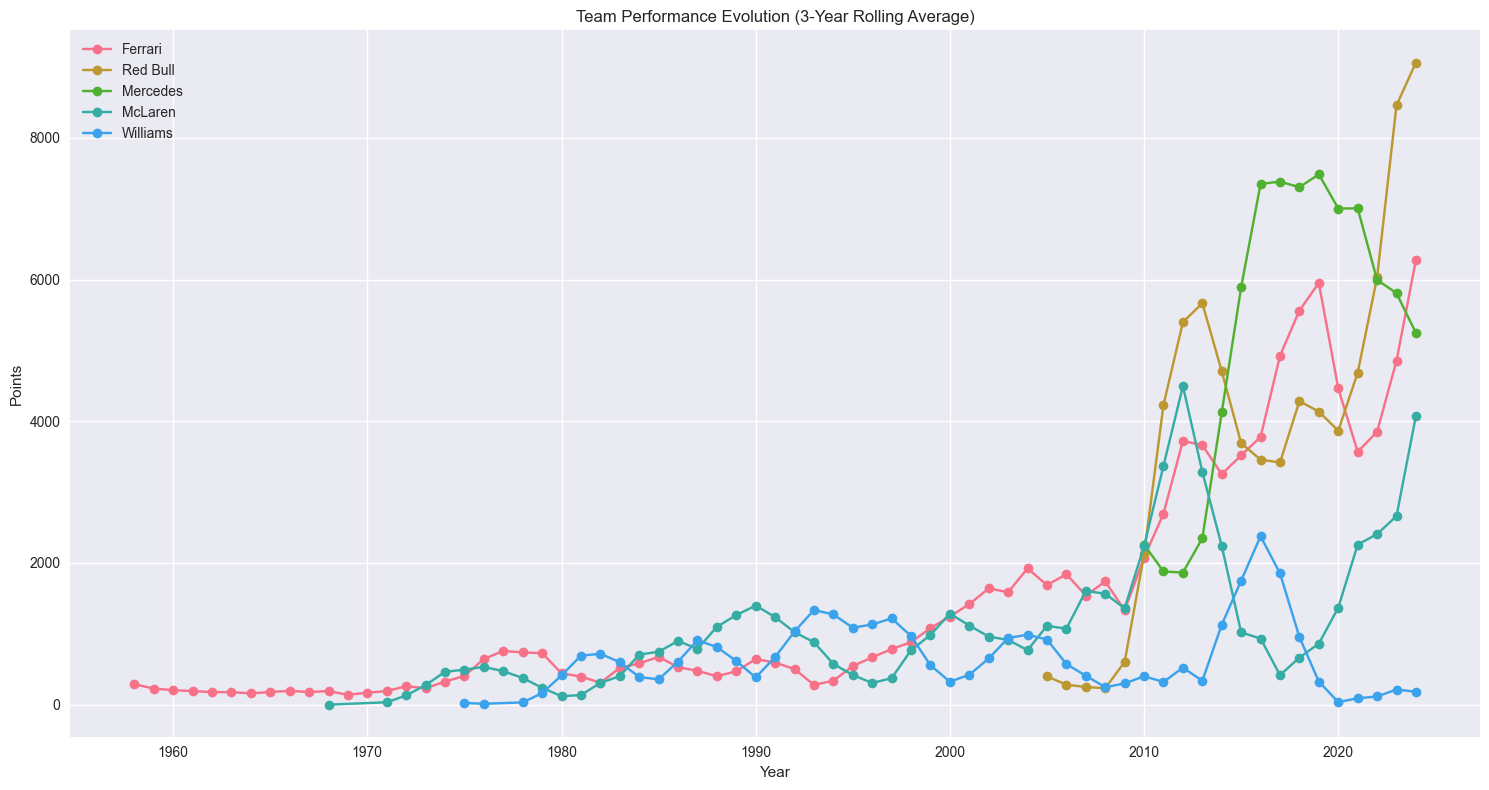

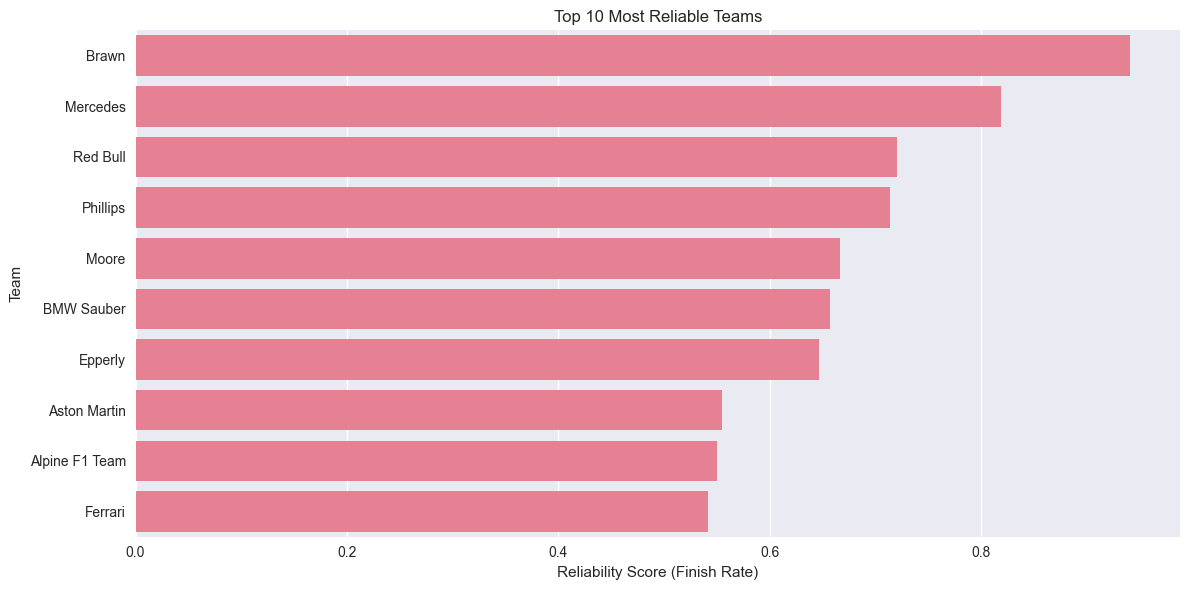

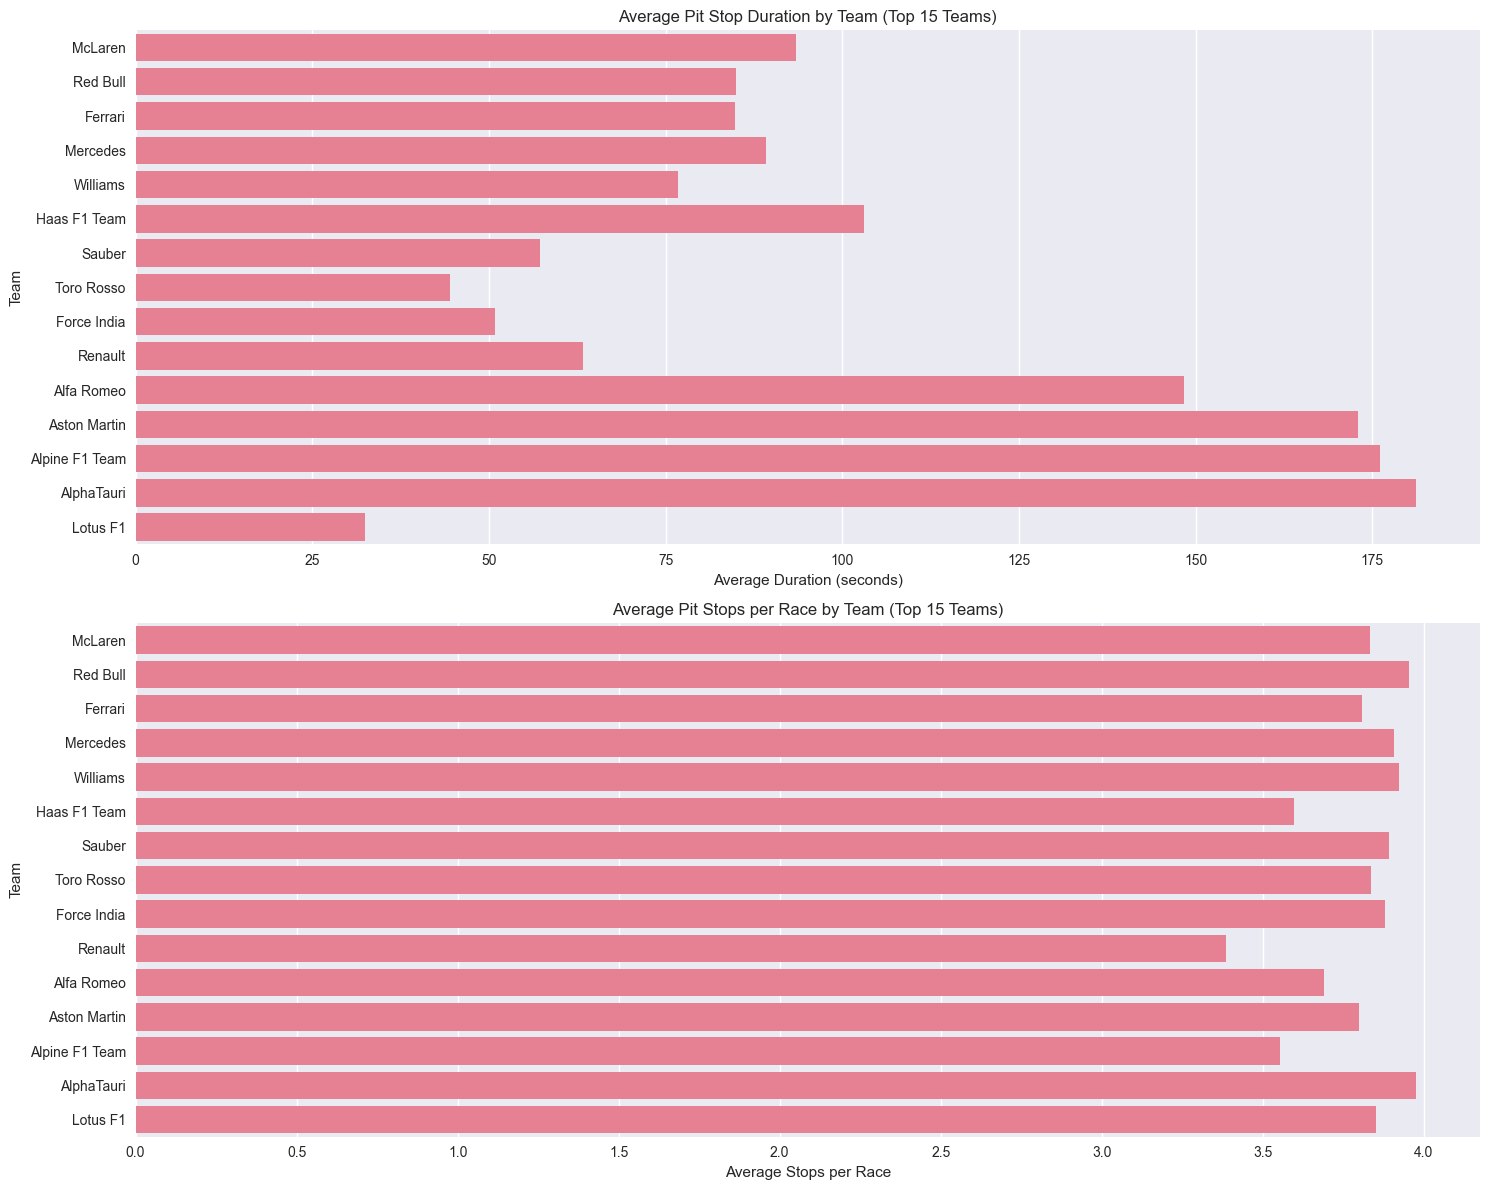


Analyzing constructor dominance periods...

Dominant Periods (Teams with >40% of points in a season):
     year           name  points_share  wins
13   1959  Cooper-Climax      0.424901    20
29   1960  Cooper-Climax      0.425876    35
44   1961        Ferrari      0.452424    24
488  1988        McLaren      0.500588   131
568  1992       Williams      0.463235    99
619  1996       Williams      0.435238   108
668  2001        Ferrari      0.410005    84
678  2002        Ferrari      0.451483   126


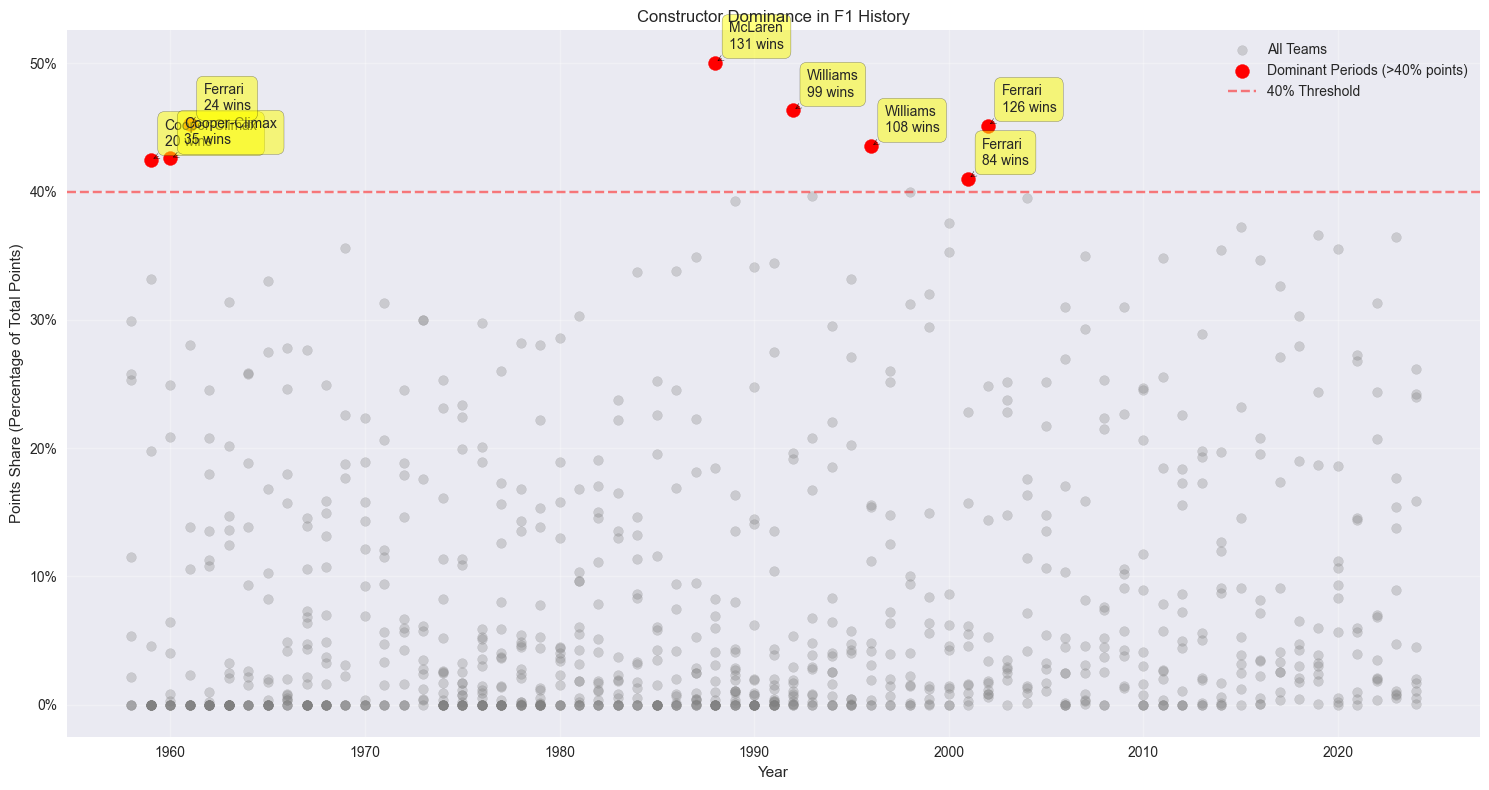

In [30]:
def main():
    # Load data
    constructors, constructor_standings, pit_stops, status, races = load_data()
    
    # 1. Team Performance Evolution
    print("\nAnalyzing team performance evolution...")
    yearly_performance = analyze_team_performance_evolution(constructor_standings)
    plot_performance_evolution(yearly_performance)
    
    # 2. Team Reliability Analysis
    print("\nAnalyzing team reliability...")
    reliability = analyze_team_reliability(status)
    print("\nTop 10 Most Reliable Teams:")
    print(reliability.nlargest(10, 'reliability_score')[['name', 'reliability_score']])
    plot_reliability_analysis(reliability)
    
    # 3. Team Strategy Analysis
    print("\nAnalyzing team strategies...")
    pit_stop_performance = analyze_team_strategies(pit_stops)
    print("\nTeam Pit Stop Performance:")
    print(pit_stop_performance[['name', 'duration', 'stops_per_race']])
    plot_strategy_analysis(pit_stop_performance)
    
    # 4. Constructor Dominance Analysis
    print("\nAnalyzing constructor dominance periods...")
    yearly_championships, dominant_periods = analyze_constructor_dominance(constructor_standings)
    print("\nDominant Periods (Teams with >40% of points in a season):")
    print(dominant_periods[['year', 'name', 'points_share', 'wins']])

    #plot_constructor_dominance
    plot_constructor_dominance(yearly_championships, dominant_periods)
    

    

if __name__ == "__main__":
    main() 